In [1]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras import layers

import jax.numpy as jnp
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
pip install polygon-api-client

In [3]:
import polygon_interface
import yahoo_interface


# **Data Processing**

In [4]:
df = yahoo_interface.get_all_features('AAPL', '2000-01-01', '2025-01-01', smoothing = True, alpha = 0.5)
df['Target'] = np.sign(df['Close'].shift(-1) - df['Close'])
df = df.dropna()
df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Timestamp,Date,Close,Volume,Open,High,Low,Vwap,MACD Value,Signal,RSI Value,Williams %R,%K,%D,%J,Target
40,954910800000,2000-04-05,0.981021,4.815438e+08,0.976504,1.011309,0.928265,0.971146,0.026576,0.034706,56.438451,-51.629915,37.081904,42.867382,25.510949,-1.0
41,954997200000,2000-04-06,0.961429,3.705855e+08,0.979624,1.011603,0.927762,0.960331,0.020687,0.031902,50.133640,-67.582179,31.343399,37.355306,19.319586,1.0
42,955083600000,2000-04-07,0.976318,3.065104e+08,0.968489,1.001876,0.935974,0.975848,0.019776,0.029477,55.852803,-61.750825,30.970855,33.132053,26.648460,-1.0
43,955342800000,2000-04-10,0.958371,2.593864e+08,0.979613,1.000304,0.937259,0.959233,0.014786,0.026539,42.857177,-78.611712,27.495989,29.936748,22.614470,-1.0
44,955429200000,2000-04-11,0.928474,4.006044e+08,0.954377,0.969894,0.912745,0.908764,0.007370,0.022705,31.214592,-90.925334,23.573012,27.346619,16.025799,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6258,1734930000000,2024-12-23,253.418928,7.142679e+07,251.368383,254.439090,249.757951,254.510176,5.765470,5.220889,73.865382,-6.554728,81.444886,78.491242,87.352175,1.0
6259,1735016400000,2024-12-24,255.667685,4.733075e+07,253.288898,256.182750,252.383785,256.950825,6.067327,5.390176,76.180657,-3.257217,89.655164,82.109529,104.746434,1.0
6260,1735189200000,2024-12-26,257.201595,3.728392e+07,255.597663,257.998543,254.865416,258.632295,6.300019,5.572145,76.812079,-4.713821,92.891745,87.997265,102.680704,-1.0
6261,1735275600000,2024-12-27,256.255445,3.981961e+07,256.572245,258.207219,253.823746,255.502422,6.137217,5.685159,69.300685,-11.535981,90.858221,91.135043,90.304576,-1.0


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


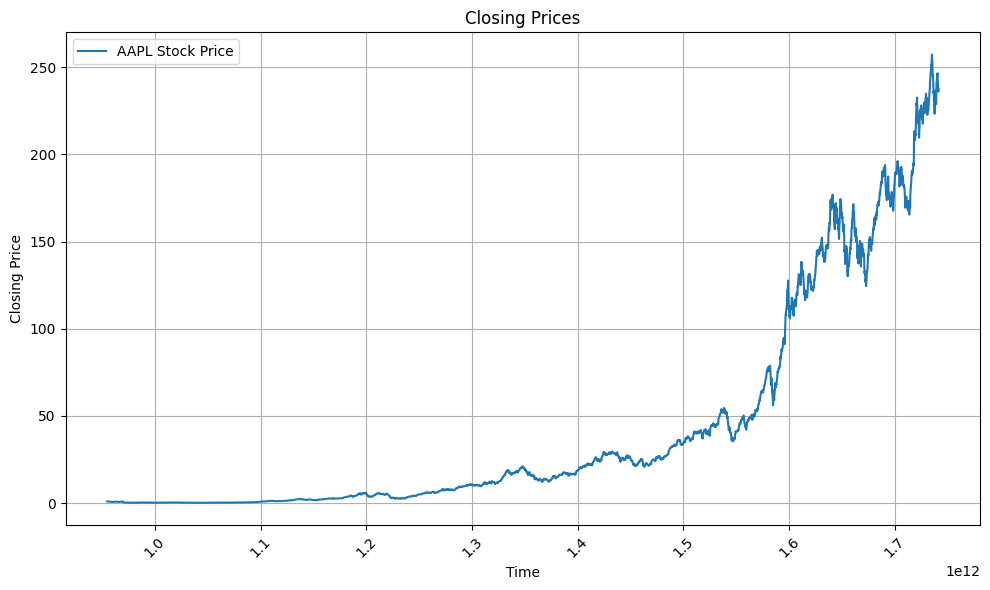

In [5]:
tickers = ['AAPL']
# Plotting the closing prices
plt.figure(figsize=(10, 6))
for ticker in tickers:
  df = yahoo_interface.get_all_features(ticker, '2000-01-01', '2025-03-10', smoothing = True, alpha = 0.5)
  plt.plot(df['Timestamp'], df['Close'], label = f'{ticker} Stock Price')
  plt.xlabel('Time')
  plt.ylabel('Closing Price')
  plt.xticks(rotation=45)
  plt.grid(True)
plt.legend()
plt.title('Closing Prices')
plt.tight_layout()
plt.show()

In [51]:
df_train = yahoo_interface.get_all_features('AAPL', '2000-01-01', '2025-01-01', smoothing = True, alpha = 0.5)
df_train['Target'] = np.sign(df_train['Close'].shift(-1) - df_train['Close'])
df_train = df_train.dropna()

df_val = yahoo_interface.get_all_features('COST', '2000-01-01', '2025-01-01', smoothing = True, alpha = 0.5)
df_val['Target'] = np.sign(df_val['Close'].shift(-1) - df_val['Close'])
df_val = df_val.dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [52]:
chunk_size = 365
window_size = 14
features = ['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R']
scaler = MinMaxScaler(feature_range = (0, 1))

X_train = []
y_train = []
X_val = []
y_val = []

le = LabelEncoder()

for i in range(len(df_train)//chunk_size + 1):
  df_chunk = df_train.iloc[i * chunk_size:(i + 1) * chunk_size].copy()
  for feature in features:
    data_chunk = df_chunk[feature]  # Get chunk
    scaled_chunk = scaler.fit_transform(data_chunk.values.reshape(-1, 1)).flatten() # Normalize chunk
    df_chunk.loc[data_chunk.index, feature] = scaled_chunk  # Assign to dataframe

  for start in range(0, len(df_chunk) - 14):
    end = start + 14
    window = df_chunk[features].iloc[start: end].to_numpy()
    target = df_chunk['Target'].iloc[end]
    X_train.append(window)
    y_train.append(target)

for i in range(len(df_val)//chunk_size + 1):
  df_chunk = df_val.iloc[i * chunk_size:(i + 1) * chunk_size].copy()
  for feature in features:
    data_chunk = df_chunk[feature]  # Get chunk
    scaled_chunk = scaler.fit_transform(data_chunk.values.reshape(-1, 1)).flatten() # Normalize chunk
    df_chunk.loc[data_chunk.index, feature] = scaled_chunk  # Assign to dataframe

  for start in range(0, len(df_chunk) - 14):
    end = start + 14
    window = df_chunk[features].iloc[start: end].to_numpy()
    target = df_chunk['Target'].iloc[end]
    X_val.append(window)
    y_val.append(target)

X_train = np.array(X_train, dtype = np.float32)
y_train = le.fit_transform(y_train)

X_val = np.array(X_val, dtype = np.float32)
y_val = le.fit_transform(y_val)

In [53]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((5971, 14, 10), (5971,), (5971, 14, 10), (5971,))

# **Model Training**

In [70]:
model = keras.Sequential([
    layers.Input((14, 10, 1)),
    layers.Conv2D(32, (7, 10), padding = 'same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (7, 10), padding = 'same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (7, 10), padding = 'same',activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2)
])

In [71]:
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_61 (Conv2D)                   │ (None, 14, 10, 32)          │           2,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 7, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 7, 5, 32)            │          71,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 3, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 3, 2, 64)            │         143,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 64)                  │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,178 (946.01 KB)

 Trainable params: 242,178 (946.01 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
model.compile(optimizer = 'adam',
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

history = model.fit(X_train,
                    y_train,
                    epochs = 50,
                    # callbacks=[callback],
                    validation_data=(X_val, y_val))

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5481 - loss: 0.6891 - val_accuracy: 0.5557 - val_loss: 0.6875
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5526 - loss: 0.6835 - val_accuracy: 0.5661 - val_loss: 0.6802
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5695 - loss: 0.6743 - val_accuracy: 0.5592 - val_loss: 0.6870
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5740 - loss: 0.6773 - val_accuracy: 0.5624 - val_loss: 0.6772
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5828 - loss: 0.6703 - val_accuracy: 0.5652 - val_loss: 0.6759
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 0.6655 - val_accuracy: 0.5679 - val_loss: 0.6771
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6115 - loss: 0.6545 - val_accuracy: 0.5781 - val_loss: 0.6749
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6151 - loss: 0.6558 - val_accuracy: 0

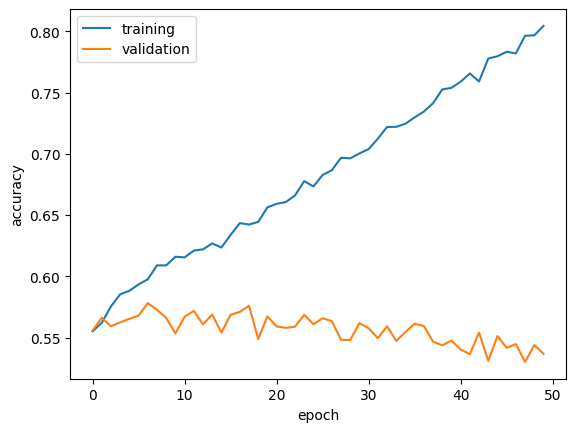

In [73]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

In [74]:
model.save_weights('CNN_weights.weights.h5')